<a href="https://colab.research.google.com/github/meliksahb/Design-of-Intelligent-Machines-ME536-/blob/main/CharacterDetectionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define characters and font
CHARZ = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
FONT_PATH = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
IMG_SIZE = 30  # Cell size
fR = 0.8
nB = int(IMG_SIZE*(1-fR))
# Generate synthetic data
def create_training_data(font_path, charz, img_size=30, num_samples_per_char=1000):
    training_data = []
    labels = []
    for idx, char in enumerate(charz):
        for _ in range(num_samples_per_char):
            # Create an image with a single character
            img = Image.new('RGB', (img_size, img_size), (255, 255, 255))
            draw = ImageDraw.Draw(img)
            font = ImageFont.truetype(font_path, size=np.random.randint(12, IMG_SIZE-1))
            x_offset = int(np.random.rand()* nB)
            y_offset = int(np.random.rand()* nB)
            draw.text((x_offset, y_offset), char, font=font, fill=(0, 0, 0))

            # Convert to grayscale and normalize
            img_array = np.array(img.convert('L'))
            training_data.append(img_array)
            labels.append(idx)

    training_data = np.array(training_data).reshape(-1, img_size, img_size, 1) / 255.0
    labels = np.array(labels)
    return training_data, labels

# Generate training data
X, y = create_training_data(FONT_PATH, CHARZ)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build the CNN
def build_cnn(input_shape=(30, 30, 1), num_classes=len(CHARZ)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the CNN
model = build_cnn()

# Train the CNN
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# # Display training history
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Save the model
model.save('character_recognition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.4939 - loss: 1.4782 - val_accuracy: 0.9733 - val_loss: 0.1329
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9851 - loss: 0.0831 - val_accuracy: 1.0000 - val_loss: 0.0203
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9997 - loss: 0.0166 - val_accuracy: 0.9978 - val_loss: 0.0113
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 1.0000 - loss: 9.7036e-04 - val_accuracy: 1.0000 - val_loss: 8.3178e-04
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 1.0000 - loss: 6.6664e

Test Accuracy: 1.00


In [31]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from PIL import ImageColor


# Define character set and colors
CHARZ = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
CHAR_COLORS = {
    'B': "pink", 'U': "yellow", 'D': "green", 'R': "orange",
    'K': "red", 'A': "cyan", 'E': "magenta", '6': "blue", 'N': "purple"
}
FONT_PATH = "/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf"  # Adjust as needed

# Load the saved CNN model
model = load_model('/content/character_recognition_model.h5')



# Function to preprocess test image and extract cells
def preprocess_gen_image(img, cell_size=30):
    """
    Preprocess the generated image to extract cells and their locations.
    """
    img_array = np.array(img)
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    cells = []
    locations = []
    for y in range(0, img_array.shape[0], cell_size):
        for x in range(0, img_array.shape[1], cell_size):
            cell = gray[y:y+cell_size, x:x+cell_size]
            if np.sum(cell < 255) > 10:  # Check for non-white pixels
                cells.append(cell)
                locations.append((x, y))
    cells = np.array(cells).reshape(-1, cell_size, cell_size, 1) / 255.0
    return cells, locations


# Function to annotate and display results
def annotate_image(img, locations, predictions, char_locations, cell_size=30):
    """
    Annotate the image with predicted characters and colors.
    """
    draw = ImageDraw.Draw(img)

    img_array = np.array(img)
    for (x, y), pred_idx in zip(locations, predictions):
        char = CHARZ[pred_idx]
        color = CHAR_COLORS[char]
        # Color the rectangle without overwriting the character
        draw.rectangle([x, y, x + cell_size, y + cell_size], outline=color, width=2)

        # Convert color name to RGB
        rgb_color = ImageColor.getrgb(color)

       # Extract the region of interest (ROI) for the character
        roi = img.crop((x, y, x + cell_size, y + cell_size))

        # Convert the ROI to a numpy array for processing
        roi_array = np.array(roi)

        # Identify the pixels that belong to the character (non-white pixels)
        mask = np.all(roi_array < [200, 200, 200], axis=-1)  # Adjust threshold as needed

        # Apply the color to the detected character
        roi_array[mask] = rgb_color  # Apply the color to the detected character

        # Convert back to an image and paste it back into the original image
        img.paste(Image.fromarray(roi_array), (x, y))

        # Store the character's location
        char_locations[char].append((x + cell_size / 2, y + cell_size / 2))

# # Function to test the CNN on saved images
# def test_saved_images(image_array, output_folder):

#     char_locations = {char: [] for char in CHARZ}

#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
#     image = np.load(image_array)
#     img = Image.fromarray(image.astype('uint8'))
#     cells, locations = preprocess_gen_image(img)

#     # Predict characters using the CNN
#     predictions = np.argmax(model.predict(cells), axis=1)

#     annotate_image(img, locations, predictions, char_locations)

#     # Save the annotated image
#     output_path = os.path.join(output_folder, "annotated_image.png")
#     img.save(output_path)
#     print(f"Processed and saved: {output_path}")

#     return char_locations, img

    # for img_path in image_paths:
          # char_locations = {char: [] for char in CHARZ}

    #     # Load the test image
    #     img = np.load(img_path)
    #     img = Image.fromarray(img.astype('uint8'))  # Convert to PIL Image

    #     # Preprocess the image to extract cells and their locations
    #     cells, locations = preprocess_gen_image(img)

    #     # Predict characters using the CNN
    #     predictions = np.argmax(model.predict(cells), axis=1)

    #     annotate_image(img, locations, predictions, char_locations)

    #     # Save the annotated image
    #     output_path = os.path.join(output_folder, os.path.basename(img_path).replace('.npy', '_annotated.png'))
    #     img.save(output_path)
    #     print(f"Processed and saved: {output_path}")
    #     # print(len(char_locations['K']))
    #     return char_locations, annotate_image

# # Paths to test images
# image_folder = '/content/'
# image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.npy')]

# # Output folder for annotated images
# output_folder = "/content/"

# # # Test on the saved images
# # test_saved_images(image_paths, output_folder)

# img = '/content/simpleF.npy'
# test_saved_images(img, output_folder)


In [69]:
import math
def distance(p1, p2):
    return math.hypot(p2[0] - p1[0], p2[1] - p1[1])

def rotate90CW(x, y):
    """
    Rotate the vector (x, y) by +90 degrees (clockwise).
    Result: (y, -x).
    """
    return (y, -x)

def rotate90CCW(x, y):
    """
    Rotate the vector (x, y) by -90 degrees (counter-clockwise).
    Result: (-y, x).
    """
    return (-y, x)

def vector(p1, p2):
    """2D vector from p1 to p2."""
    return (p2[0] - p1[0], p2[1] - p1[1])

def dot_product(v1, v2):
    """Dot product of two 2D vectors."""
    return v1[0]*v2[0] + v1[1]*v2[1]

def is_perpendicular(p1, p2, p3, tol=1e-5):
    """
    Check if the angle at p2 (formed by p2->p1 and p2->p3) is ~90 degrees.
    """
    v1 = vector(p2, p1)
    v2 = vector(p2, p3)
    return abs(dot_product(v1, v2)) < tol

def is_square(kpt, apt, rpt, ept, dist_tol=1e-5, angle_tol=1e-5):
    """
    Checks if points (K, A, R, E) form a square in order K->A->R->E->K.
    1) All sides ~ equal
    2) All angles ~ 90 degrees
    """
    dKA = distance(kpt, apt)
    dAR = distance(apt, rpt)
    dRE = distance(rpt, ept)
    dEK = distance(ept, kpt)

    sides = [dKA, dAR, dRE, dEK]
    mean_side = sum(sides) / 4.0

    # Check side lengths
    for s in sides:
        if abs(s - mean_side) > dist_tol:
            return False

    # Check angles at A, R, E, K
    if (not is_perpendicular(kpt, apt, rpt, angle_tol) or
        not is_perpendicular(apt, rpt, ept, angle_tol) or
        not is_perpendicular(rpt, ept, kpt, angle_tol) or
        not is_perpendicular(ept, kpt, apt, angle_tol)):
        return False

    return True

def find_neighbors(letter_points, est_point, max_dist=3.0):
    """
    Return all points in `letter_points` that are within `max_dist` of `est_point`.
    """
    candidates = []
    for p in letter_points:
        if distance(p, est_point) <= max_dist:
            candidates.append(p)
    return candidates

def find_best_square(k_points, a_points, r_points, e_points,
                     dist_tol=1e-5, angle_tol=1e-5):
    """
    Search all combos of K, A, R, E points, return the "best" square
    (largest side). If none found, returns None.
    """
    best_square_pts = None
    best_side_len = 0.0

    for kpt in k_points:
        for apt in a_points:
            for rpt in r_points:
                for ept in e_points:
                    if is_square(kpt, apt, rpt, ept, dist_tol, angle_tol):
                        # Use distance(K, A) as side length
                        side_len = distance(kpt, apt)
                        if side_len > best_side_len:
                            best_side_len = side_len
                            best_square_pts = (kpt, apt, rpt, ept)

    return best_square_pts

def find_all_squares_kare_optimized(k_points, a_points, r_points, e_points,
                                    dist_tol=1e-5, angle_tol=1e-5,
                                    corner_tol=3.0):
    """
    Return a list of *all* squares (K, A, R, E) that form a valid K->A->R->E->K
    using the geometry approach:
      - For each (K, A), compute the two possible corners R_est, E_est by rotating KA
        +90° or -90° around A, and similarly around K.
      - Find actual R in r_points near R_est, actual E in e_points near E_est.
      - For each candidate, do a final is_square(...) check.
    corner_tol = max distance in pixels to consider a point "matching" the computed corner.
    """
    squares_found = []

    for kpt in k_points:
        for apt in a_points:
            # Vector K->A
            vx = apt[0] - kpt[0]
            vy = apt[1] - kpt[1]
            if abs(vx) < 1e-7 and abs(vy) < 1e-7:
                # kpt == apt? skip
                continue

            # 1) CW orientation: rotate (K->A) by +90 deg around A => A->R
            #    Also rotate (K->A) by +90 deg around K => K->E
            #    Then R_est = A + rotate90CW(K->A)
            #         E_est = K + rotate90CW(K->A)
            vx_cw, vy_cw = rotate90CW(vx, vy)
            r_est_cw = (apt[0] + vx_cw, apt[1] + vy_cw)
            e_est_cw = (kpt[0] + vx_cw, kpt[1] + vy_cw)

            # 2) CCW orientation: rotate (K->A) by -90 deg around A => A->R
            #                     rotate (K->A) by -90 deg around K => K->E
            vx_ccw, vy_ccw = rotate90CCW(vx, vy)
            r_est_ccw = (apt[0] + vx_ccw, apt[1] + vy_ccw)
            e_est_ccw = (kpt[0] + vx_ccw, kpt[1] + vy_ccw)

            # Now find actual R points near r_est_cw, E points near e_est_cw, etc.
            # We'll do for BOTH cw and ccw:
            #    For each r in neighbors..., e in neighbors..., check is_square(k,a,r,e).

            # Check CW
            r_candidates_cw = find_neighbors(r_points, r_est_cw, corner_tol)
            e_candidates_cw = find_neighbors(e_points, e_est_cw, corner_tol)
            for rpt in r_candidates_cw:
                for ept in e_candidates_cw:
                    if is_square(kpt, apt, rpt, ept, dist_tol, angle_tol):
                        squares_found.append((kpt, apt, rpt, ept))

            # Check CCW
            r_candidates_ccw = find_neighbors(r_points, r_est_ccw, corner_tol)
            e_candidates_ccw = find_neighbors(e_points, e_est_ccw, corner_tol)
            for rpt in r_candidates_ccw:
                for ept in e_candidates_ccw:
                    if is_square(kpt, apt, rpt, ept, dist_tol, angle_tol):
                        squares_found.append((kpt, apt, rpt, ept))

    return squares_found

def draw_squares_pil(pil_image, squares, color='lime', width=3):
    """
    squares is a list of (K, A, R, E) points.
    Draw each square in order K->A->R->E->K.
    """
    draw = ImageDraw.Draw(pil_image)
    for (kpt, apt, rpt, ept) in squares:
        kpt_i = (int(kpt[0]), int(kpt[1]))
        apt_i = (int(apt[0]), int(apt[1]))
        rpt_i = (int(rpt[0]), int(rpt[1]))
        ept_i = (int(ept[0]), int(ept[1]))

        draw.line([kpt_i, apt_i], fill=color, width=width)
        draw.line([apt_i, rpt_i], fill=color, width=width)
        draw.line([rpt_i, ept_i], fill=color, width=width)
        draw.line([ept_i, kpt_i], fill=color, width=width)

def build_grid_of_letters(img, cell_size=30):
    """
    1) Preprocess the image => get (cells, locations).
    2) Predict letters => fill a 2D array 'grid' with each letter or None.
    3) Return grid, plus the 'reverse_map' that knows (row,col)->(x,y) in pixels.
    """
    pil_img = Image.fromarray(img.astype('uint8'))
    cells, locations = preprocess_gen_image(pil_img, cell_size=cell_size)
    # e.g. your function that segments the image
    # locations[i] = (x, y) top-left corner of the i-th cell

    pred_indices = np.argmax(model.predict(cells), axis=1)
    letters = [CHARZ[idx] for idx in pred_indices]  # e.g. 'B','U', etc.

    # figure out how many rows & cols
    # Usually, the puzzle is (height // cell_size) rows, (width // cell_size) cols
    w, h = pil_img.size
    n_rows = h // cell_size
    n_cols = w // cell_size

    # build a 2D array of None
    grid = [[None for _ in range(n_cols)] for _ in range(n_rows)]
    # also keep track of the pixel coordinate of each (row, col) => for drawing
    reverse_map = [[(0,0) for _ in range(n_cols)] for _ in range(n_rows)]

    for i, (x, y) in enumerate(locations):
        c = letters[i]  # predicted letter
        row = y // cell_size
        col = x // cell_size
        if 0 <= row < n_rows and 0 <= col < n_cols:
            grid[row][col] = c
            # store the top-left corner or center for later drawing
            # here, let's store the *center* if you prefer
            center_x = x + cell_size/2.0
            center_y = y + cell_size/2.0
            reverse_map[row][col] = (center_x, center_y)

    return grid, reverse_map

from collections import deque

directions_8 = [
    (-1, 0),  # up
    (-1, 1),  # up-right
    (0, 1),   # right
    (1, 1),   # down-right
    (1, 0),   # down
    (1, -1),  # down-left
    (0, -1),  # left
    (-1, -1)  # up-left
]

def bfs_find_letter(
    grid,  # 2D array of letters or None
    start_positions,  # list of (r, c) from which BFS will begin
    target_letter,    # e.g. 'U' or 'D'
):
    """
    BFS from the set of start_positions in 8 directions,
    searching for all cells containing target_letter.

    Returns:
      - found_positions: list of (r, c) that contain target_letter
                         and were reached from BFS
      - parent: dict of {(r, c): (r_prev, c_prev)} for path reconstruction
                from the BFS expansions.
                (No need to store the letter index here, since each BFS
                 only aims for the *next* letter.)
    """
    n_rows = len(grid)
    n_cols = len(grid[0]) if n_rows > 0 else 0

    # Mark visited to avoid revisiting
    visited = [[False]*n_cols for _ in range(n_rows)]
    parent = {}

    # Initialize queue with all start positions
    queue = deque()
    for (sr, sc) in start_positions:
        visited[sr][sc] = True
        parent[(sr, sc)] = None  # no parent
        queue.append((sr, sc))

    found_positions = []

    while queue:
        (r, c) = queue.popleft()

        # If this cell is the target letter, record it
        if grid[r][c] == target_letter:
            found_positions.append((r, c))
            # We do NOT stop BFS here, because we want *all* occurrences
            # of the target letter that can be reached from any start.

        # Explore neighbors
        for (dr, dc) in directions_8:
            rr = r + dr
            cc = c + dc
            if 0 <= rr < n_rows and 0 <= cc < n_cols:
                if not visited[rr][cc]:
                    visited[rr][cc] = True
                    parent[(rr, cc)] = (r, c)
                    queue.append((rr, cc))

    return found_positions, parent

def find_path_BUDUR_8dir(grid):
    """
    Finds the shortest path in 'grid' that spells B->U->D->U->R,
    allowing 8-direction adjacency.

    Returns list of (r, c) if found, else None.
    """
    word = "BUDUR"
    # 0:'B', 1:'U', 2:'D', 3:'U', 4:'R'

    n_rows = len(grid)
    n_cols = len(grid[0]) if n_rows>0 else 0

    # Stage 0: locate all 'B' in the grid.
    b_positions = []
    for r in range(n_rows):
        for c in range(n_cols):
            if grid[r][c] == 'B':
                b_positions.append((r, c))
    if not b_positions:
        return None

    # We need an array to store BFS parent for each stage
    # parent_list[i][ (r,c) ] => (pr, pc)
    parent_list = [dict() for _ in range(len(word))]

    # For BFS #1 (B->U), the start set is b_positions
    current_positions = b_positions

    # We'll do BFS for each transition: i=0..3
    # letter from word[i] to word[i+1]
    for i in range(len(word)-1):
        start_letter = word[i]
        next_letter = word[i+1]

        # BFS from current_positions to find all next_letter
        found_positions, parent = bfs_find_letter(grid, current_positions, next_letter)
        parent_list[i+1] = parent  # store parent dictionary for BFS i+1

        if not found_positions:
            # cannot proceed
            return None
        # found_positions are the start positions for the next BFS
        current_positions = found_positions

    # After the final BFS (stage 4 for letter R), current_positions has all R cells
    # We'll pick ANY of them to reconstruct the path
    # Because BFS is shortest path, the first we find is fine.
    # But we have "all" R cells. Let's just pick the first.
    if not current_positions:
        return None

    # pick one R cell, e.g. current_positions[0]
    final_rc = current_positions[0]
    final_letter_idx = 4  # for 'R'

    # Now reconstruct from R all the way back to B
    path_rc = []
    cur = final_rc
    stage = final_letter_idx  # 4

    while stage >= 0 and cur is not None:
        path_rc.append(cur)
        par = parent_list[stage].get(cur)  # parent of cur in BFS for stage
        cur = par
        stage -= 1

    path_rc.reverse()
    # That should be the path B->U->D->U->R (if everything lines up).
    # Check length == 5, optional.
    if len(path_rc) == 5:
        return path_rc
    else:
        return None

def draw_budur_path_8dir(pil_image, path_rc, reverse_map, color='blue', width=3):
    draw = ImageDraw.Draw(pil_image)
    pixel_points = [reverse_map[r][c] for (r,c) in path_rc]
    pixel_points = [(int(x), int(y)) for (x,y) in pixel_points]
    for i in range(len(pixel_points)-1):
        draw.line([pixel_points[i], pixel_points[i+1]], fill=color, width=width)

def cross(o, a, b):
    """
    2D cross product of OA x OB.
    Returns >0 if O->A->B is CCW,
            <0 if CW,
             0 if collinear.
    """
    return (a[0] - o[0])*(b[1] - o[1]) - (a[1] - o[1])*(b[0] - o[0])

def is_convex_or_collinear_polygon(pts):
    """
    Checks if polygon (pts[0], ..., pts[n-1]) is 'weakly' convex or collinear:
      - All corners turn consistently clockwise or consistently ccw,
      - Collinearity is allowed.
    Returns True if the shape is 'convex or collinear', False otherwise.
    """
    n = len(pts)
    if n < 3:
        return False

    sign = 0
    for i in range(n):
        p0 = pts[(i - 1) % n]
        p1 = pts[i]
        p2 = pts[(i + 1) % n]
        c = cross(p1, p0, p2)

        if sign == 0 and c != 0:
            sign = 1 if c > 0 else -1
        else:
            if c != 0:
                # If c flips sign => reflex => not convex
                if (c > 0 and sign < 0) or (c < 0 and sign > 0):
                    return False
    return True

def polygon_area(pts):
    """
    Shoelace formula for polygon area. 'pts' is in (x,y) order around the polygon.
    """
    n = len(pts)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += pts[i][0] * pts[j][1] - pts[j][0] * pts[i][1]
    return abs(area) / 2.0

def compute_convex_hull(points):
    """
    Andrew's monotone chain, but modified to KEEP collinear points on hull.
    Returns a list of hull vertices in CCW order (excluding the last repeated point).
    """
    pts = sorted(points)  # sort by x, then by y
    if len(pts) <= 1:
        return pts

    # Build lower hull
    lower = []
    for p in pts:
        # Pop only if we have a strictly clockwise turn (cross < 0).
        # If cross == 0 => collinear => keep it.
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) < 0:
            lower.pop()
        lower.append(p)

    # Build upper hull
    upper = []
    for p in reversed(pts):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) < 0:
            upper.pop()
        upper.append(p)

    # Concatenate lower + upper minus the duplicated endpoints
    lower.pop()
    upper.pop()
    hull = lower + upper
    return hull  # in CCW order

def find_best_6kenar(six_pts, k_pts, e_pts, n_pts, a_pts, r_pts):
    """
    1) Combine all letter-points into a single set.
    2) Compute hull (keeping collinear boundary points).
    3) In hull's CCW order, search for a subsequence labeled 6->K->E->N->A->R.
    4) Check final polygon for convexity/collinearity. If valid, update best.
    """
    from collections import defaultdict

    # 1) Combine points with letter tags
    all_points = []
    for p in six_pts:
        all_points.append((p[0], p[1], '6'))
    for p in k_pts:
        all_points.append((p[0], p[1], 'K'))
    for p in e_pts:
        all_points.append((p[0], p[1], 'E'))
    for p in n_pts:
        all_points.append((p[0], p[1], 'N'))
    for p in a_pts:
        all_points.append((p[0], p[1], 'A'))
    for p in r_pts:
        all_points.append((p[0], p[1], 'R'))

    if not all_points:
        return None

    # 2) Compute hull on (x,y)
    xy_points = [(p[0], p[1]) for p in all_points]
    hull = compute_convex_hull(xy_points)  # CCW order
    hull_set = set(hull)

    # 3) Keep only those that appear on hull
    hull_points = []
    for p in all_points:
        if (p[0], p[1]) in hull_set:
            hull_points.append(p)

    # Put them in the same CCW order as hull
    ordered_hull_points = []
    for hv in hull:
        # gather all letters at that (x,y)
        same_coords = [pt for pt in hull_points if pt[0] == hv[0] and pt[1] == hv[1]]
        ordered_hull_points.extend(same_coords)

    # 4) Search for subsequence 6->K->E->N->A->R in CCW order
    best_area = 0.0
    best_hex = None
    N = len(ordered_hull_points)

    for i1 in range(N):
        if ordered_hull_points[i1][2] != '6':
            continue
        for i2 in range(i1 + 1, N):
            if ordered_hull_points[i2][2] != 'K':
                continue
            for i3 in range(i2 + 1, N):
                if ordered_hull_points[i3][2] != 'E':
                    continue
                for i4 in range(i3 + 1, N):
                    if ordered_hull_points[i4][2] != 'N':
                        continue
                    for i5 in range(i4 + 1, N):
                        if ordered_hull_points[i5][2] != 'A':
                            continue
                        for i6 in range(i5 + 1, N):
                            if ordered_hull_points[i6][2] != 'R':
                                continue

                            # Build the 6-vertex polygon in that CCW letter order
                            poly = [
                                (ordered_hull_points[i1][0], ordered_hull_points[i1][1]),
                                (ordered_hull_points[i2][0], ordered_hull_points[i2][1]),
                                (ordered_hull_points[i3][0], ordered_hull_points[i3][1]),
                                (ordered_hull_points[i4][0], ordered_hull_points[i4][1]),
                                (ordered_hull_points[i5][0], ordered_hull_points[i5][1]),
                                (ordered_hull_points[i6][0], ordered_hull_points[i6][1]),
                            ]
                            # -- NEW: final check to exclude non-convex polygons --
                            if not is_convex_or_collinear_polygon(poly):
                                continue

                            area = polygon_area(poly)
                            if area > best_area:
                                best_area = area
                                best_hex = poly

    return best_hex

def draw_hexagon_pil(pil_img, hex_points, color='lime', width=3):
    """
    Draw lines connecting the 6 points in order, then close the polygon.
    """
    from PIL import ImageDraw
    draw = ImageDraw.Draw(pil_img)
    coords = [(int(p[0]), int(p[1])) for p in hex_points]
    n = len(coords)
    for i in range(n):
        j = (i+1) % n
        draw.line([coords[i], coords[j]], fill=color, width=width)

In [70]:
def SearchInAlphabetSoup(img, txt='KARE'):
    """
    Given an image (numpy array) and a text (default 'KARE'),
    - If txt == 'KARE', attempt to find centers of K, A, R, E that form a square.
    - If found, draw the largest square on a copy of the image and return it.
    - Otherwise, return the original or some other processed result for other words.
    """
    # Convert the input array to PIL
    pil_img = Image.fromarray(img.astype('uint8'))

    # Preprocess => get cells + their top-left corners
    cells, locations = preprocess_gen_image(pil_img)

    # CNN predictions
    predictions = np.argmax(model.predict(cells), axis=1)
    cell_size=30
    # We'll store locations for each recognized character
    char_locations = {c: [] for c in CHARZ}
    grid, reverse_map = build_grid_of_letters(img, cell_size=cell_size)
    # Annotate (color) each detected character in the PIL image
    annotate_image(pil_img, locations, predictions, char_locations, cell_size=cell_size)

    # If the user wants 'KARE', attempt to find the square
    if txt.upper() == 'KARE':
        k_points = char_locations['K']
        a_points = char_locations['A']
        r_points = char_locations['R']
        e_points = char_locations['E']

        if not (k_points and a_points and r_points and e_points):
            print("Cannot form KARE because letters are missing.")
        else:
            # Find *all* squares
            squares = find_all_squares_kare_optimized(k_points, a_points,
                                                      r_points, e_points,
                                                      dist_tol=2,     # or small
                                                      angle_tol=1e-3, # or small
                                                      corner_tol=3.0) # neighbor radius
            if squares:
                print(f"Found {len(squares)} KARE squares.")
                draw_squares_pil(pil_img, squares, color='red', width=10)
            else:
                print("No valid KARE squares found.")
    elif txt.upper() == 'BUDUR':
        path_rc = find_path_BUDUR_8dir(grid)
        if path_rc is not None:
            draw_budur_path_8dir(pil_img, path_rc, reverse_map, color='black', width=10)
            print("BUDUR path found (8-dir layered BFS):", path_rc)
        else:
            print("No valid BUDUR path found.")
    elif txt.upper() == '6KENAR':
        six_pts = char_locations['6']
        k_pts   = char_locations['K']
        e_pts   = char_locations['E']
        n_pts   = char_locations['N']
        a_pts   = char_locations['A']
        r_pts   = char_locations['R']

        if six_pts and k_pts and e_pts and n_pts and a_pts and r_pts:
            best_hex = find_best_6kenar(six_pts, k_pts, e_pts, n_pts, a_pts, r_pts)
            if best_hex is not None:
                draw_hexagon_pil(pil_img, best_hex, color='lime', width=10)
                print("Largest 6KENAR found with area:", polygon_area(best_hex))
            else:
                print("No valid convex 6KENAR found.")
    else:
        # If you want to handle other words differently, do so here.
        print(f"No special square detection for '{txt}'.")

    # Return the annotated PIL image
    return pil_img

In [71]:
# test codes -to be added to the end of your code
# the SearchInAlphabetSoup() function you wrote will be called several times
# during this test.

# import for imread, just in case
import matplotlib.pyplot as plt
from matplotlib.image import imread
from timeit import default_timer as timer
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random

# get the necessary file
!rm *.jpg 2>/dev/null
!wget https://raw.githubusercontent.com/bugrakoku/data4all/main/crashed.jpg



def GenImage(numLetters = 50, fixedFontSize = True, xCount = 15, yCount = 10, pos = [], cvals = [] ):
    '''
    Input:
        numLetters = maximum number of letters
        fixedFontSize = well doug
        xCount, yCount = number of rows and columns
        pos and cvals = pre-allocated positions of characters

    Output:
        image as numpy array that contains letters randomly located
    '''
    # in the assignment assessment following will not change in test images
    fontname = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
    cellSize = 30 #cell within which a single char will be printed
    BackColor = (255,255, 255) # back color
    ForeColor = (0, 0, 0) # font color
    charz = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
    # in the assignment assessment variable above will not change in generating test images
    fR = 0.8 # font ratio to cell size
    # generate an empty list to be filled in randomly
    #charmap = [['' for i in range(xCount)] for j in range(yCount)] # assign

    fontsize = int(cellSize * fR) # fixed font size
    nB = int(cellSize*(1-fR)) # location noise

    img = Image.new('RGB', (xCount*cellSize,yCount*cellSize), BackColor ) # blank image
    imgPen = ImageDraw.Draw(img) # pen to draw on the blank image

    # first generate random positions over pos
    # note that pos might be already partially filled in
    for i in range(len(pos), numLetters):
        x = np.random.randint(0, xCount)
        y = np.random.randint(0, yCount)
        if [y,x] not in pos:
            pos.append([y,x])
            cvals.append(random.choice(charz))
    print(f'size: {len(pos)}:{len(cvals)}')
    # now that positions are determined, print random letters in them
    for ([y,x], txt) in zip(pos, cvals): # draw each letter if random location is not already occupied, if occupied, skip
        if not fixedFontSize: # if set so, select a random font size
            fontsize = np.random.randint(12, cellSize-1)
            dx, dy = 0, 0 # when scaled, position does not change
        else: # add some location noise
            dx = int(np.random.rand()* nB)
            dy = int(np.random.rand()* nB)
        font = ImageFont.truetype(fontname, fontsize) # font instace created
        imgPen.text((x * cellSize + dx, y * cellSize + dy), txt, font=font, fill=ForeColor) # write the character to blank image


    return np.array(img) # finally return image as an numpy array

test_basic = ['simplest']
test_more = ['simple', 'test50', 'test100']
test_pro = ['test150', 'test250', 'test400', 'testInsane']
test_all = test_basic + test_more + test_pro
# the following are variable font size cases
test_basicF = ['simplestF']
test_moreF = ['simpleF', 'test50F', 'test100F']
test_ProF = ['test150F', 'test250F', 'test400F', 'testInsaneF']
test_allF = test_basicF + test_moreF + test_ProF

def PerformTest(cases = ['simplest'], figSize = (50,50)):
    shapes = ['KARE', 'BUDUR', '6KENAR']
    crash = imread('crashed.jpg')
    imgz = []
    imgTitles = []
    for case in cases:
        img = np.load(f'{case}.npy')
        for shape in shapes:
            startTime = timer()
            try:
                print(f'Searching for {shape} in {case} ')
                imgR = SearchInAlphabetSoup(img.copy(), shape)
                imgz.append(imgR)
            except:
                imgz.append(crash)
            endTime = timer()
            imgTitles.append(f'{shape} in {case}: {round(endTime-startTime, 3)} sec.')
            print(imgTitles[-1])

    # finally plot the results
    fig, axz = plt.subplots(len(imgz), 1, figsize=figSize)
    for i, ax in enumerate(axz):
        ax.imshow(imgz[i])
        ax.set_title(imgTitles[i])

# make suer the crashed image shows up
# plt.imshow(plt.imread('crashed.jpg'))
# plt.title('just checking the crash.jpg image... no worries yet...')

--2025-01-08 20:57:54--  https://raw.githubusercontent.com/bugrakoku/data4all/main/crashed.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14301 (14K) [image/jpeg]
Saving to: ‘crashed.jpg’

crashed.jpg         100%[===================>]  13.97K  --.-KB/s    in 0s      

2025-01-08 20:57:54 (33.3 MB/s) - ‘crashed.jpg’ saved [14301/14301]



size: 15:15
size: 15:15
size: 27:27
size: 27:27
size: 50:50
size: 93:93
size: 125:125
size: 196:196
size: 252:252
size: 616:616
size: 48:48
size: 90:90
size: 126:126
size: 186:186
size: 262:262
size: 623:623


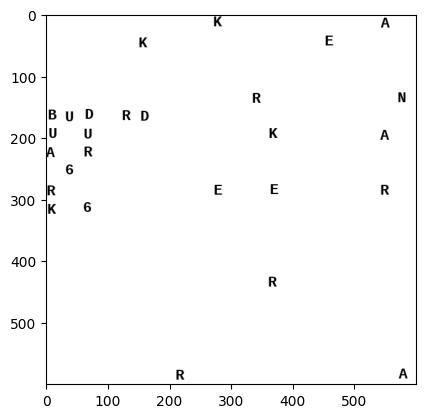

In [72]:
# simplest case
ch = ['K', 'A', 'R', 'E',
      'B', 'U', 'D', 'U', 'R',
      '6', 'K', 'E', 'N', 'A', 'R'
]
pos = [[0,9], [0,13], [4,13], [4, 9],
        [5,0], [5,1], [5,2], [6,2], [7,2],
        [10, 5], [7,7], [7,11], [10, 13 ], [13,11], [13,7],
]
img = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
imgF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
np.save('simplest', img)
np.save('simplestF', imgF)

# simple case
ch = ['K', 'A', 'R', 'E',
      'A', 'R', 'E',
      'B', 'U', 'D', 'U', 'R',
      'U', 'A', 'R', 'K',
      'R', 'D',
      'K', '6', 'R',
      '6', 'K', 'E', 'N', 'A', 'R'
      ]
pos = [[0,9], [0,18], [9,18], [9, 9],
        [6, 18], [4, 11], [9, 12],
        [5,0], [5,1], [5,2], [6,2], [7,2],
        [6,0], [7,0], [9,0], [10,0],
        [5,4], [5,5],
        [6, 12], [10, 2], [14, 12] ]

# add slightly randomized 6KENAR
pos.append([np.random.randint(7, 17), 1]) #6
pos.append([1, np.random.randint(0, 6)]) #K
pos.append([1, np.random.randint(14, 20)]) #E
pos.append([np.random.randint(4, 8), 19]) #N
pos.append([np.random.randint(17, 20), 19]) #A
pos.append([19, np.random.randint(5, 13)]) #R

img = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
imgF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
plt.imshow(img)
np.save('simple', img)
np.save('simpleF', imgF)


# fixed font size cases
img50 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=50)
img100 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=100)
img150 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=150)
img250 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=250)
img400 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=400)
imgInsane = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=25, yCount=25, numLetters=3000)
np.save('test50', img50)
np.save('test100', img100)
np.save('test150', img150)
np.save('test250', img250)
np.save('test400', img400)
np.save('testInsane', imgInsane)

# variable font size cases
img50F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=50)
img100F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=100)
img150F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=150)
img250F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=250)
img400F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=400)
imgInsaneF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=25, yCount=25, numLetters=3000)
np.save('test50F', img50F)
np.save('test100F', img100F)
np.save('test150F', img150F)
np.save('test250F', img250F)
np.save('test400F', img400F)
np.save('testInsaneF', imgInsaneF)
#'''

Searching for KARE in simplest 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Found 1 KARE squares.
KARE in simplest: 0.186 sec.
Searching for BUDUR in simplest 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
BUDUR path found (8-dir layered BFS): [(5, 0), (5, 1), (5, 2), (6, 2), (7, 2)]
BUDUR in simplest: 0.224 sec.
Searching for 6KENAR in simplest 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
No valid convex 6KENAR found.
6KENAR in simplest: 0.191 sec.
Searching for KARE in simple 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Found 1 KARE squares.
KARE in simple: 0.194 sec.
Searching for BUDUR in simple 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
BUDUR path found (8-dir layered BFS): [(5, 0), (5, 1), (5, 2), (6, 2), (7, 2)]
BUDUR in simple: 0.194 sec.
Searching for 6KENAR in simple 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━

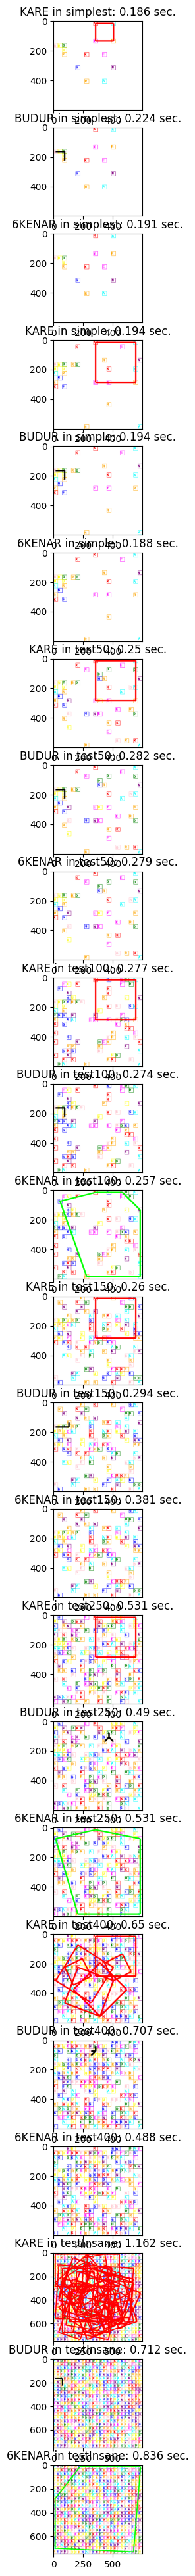

In [73]:
# fixed size font test
# if you trust your code, test them all togather
# or change the following to run one by one try it a few times you will get to the bottom of it
#PerformTest(test_basic)
PerformTest(test_all)

In [ ]:
# variable sized font tests
PerformTest(test_allF)